# Image Alignment and OCR
Also referred to as _image registration_.
Used in building panoramic photos, making HDR images from multiple photos, and in medical field to highlight small changes between image scans.
We'll look at HDR & panorama next week, but for today, let's explore this with regards to documents.

## Align an image to a template.
![alt text](image-alignment-using-opencv.jpg "Image Alignment")

## Theory

### Common Transformations
![alt text](motion-models.jpg "Motion Models")
Type 1 (preserve dimensions)
* Translation - simple shift in pixel coordinates.
* Euclidian - e.g. rotation

Type 2 (with distortion)
* Affine - encompass Euclidian transformations, but also include shear & scale changes _Note how parallel lines remain parallel_
* Homography - most generally used for 2d images, transforms original shape (square) into an arbitrary quadrilateral

### Homography
At the heart of image alignment techniques is a simple 3×3 matrix called Homography.
Useful coz it allows us to warp an image to essentially change its perspective.

Two images of a scene are related by a homography under two conditions.

1. The two images are that of a plane (e.g. sheet of paper, credit card etc.).
2. The two images were acquired by rotating the camera about its optical axis. _We take such images while generating panoramas, for example_

A homography is nothing but a 3×3 matrix, as shown

!["Homography Matrix"](homography-matrix.webp)|

Let (x_1,y_1) be a point in the first image and (x_2,y_2)} be the coordinates of the same physical point in the second image. Then, the Homography H relates them in the following way

!["Homography Matrix Transformation"](homography-matrix-trans.webp)|

If we knew the homography, we could apply it to all the pixels of one image to obtain a warped image that is aligned with the second image.

So, if, for example, we want a **Homography** that transforms a square to arbitrary quad (see above).  We need:
* Images of two planes related by a **Homography**
* **4 corresponding points** to estimate the Homography


!["Homography Example"](homography-example.jpg)|

In [10]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Simple Manual Example
We have some playing cards and we want to align the top card to be flat.

In [28]:
# Read cards image
cardsFilename = "playing_cards.jpg"
print("Reading cards image : ", cardsFilename)
im_c = cv2.imread(cardsFilename, cv2.IMREAD_COLOR)
im_c = cv2.cvtColor(im_c, cv2.COLOR_BGR2RGB)

Reading cards image :  playing_cards.jpg


Text(0.5, 1.0, 'Original Form of Cards Image')

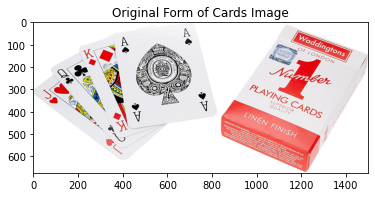

In [29]:
plt.imshow(im_c); plt.title("Original Form of Cards Image")

In [31]:
#a typical playing card is 2.5 by 3.5 inches
width, height = 250, 350

# define points in original image and their corresponding points in the new (flat) image
pts1 = np.float32([[367,54],[700,3],[436,468],[816,410]]) #tl, tr, bl, br
pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])

In [32]:
#create transformation/homography matrix
trans_matrix = cv2.getPerspectiveTransform(pts1,pts2)

#warp the image based on the matrix
output_image = cv2.warpPerspective(im_c, trans_matrix, (width, height))

Text(0.5, 1.0, 'Warped/Aligned Form of Cards Image')

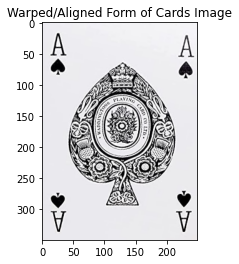

In [33]:
#display aligned image
plt.imshow(output_image); plt.title("Warped/Aligned Form of Cards Image")

# Now, let's do it automatically using a Template
Image Sources: [LearnOpenCV.com](https://learnopencv.com/)
## Step 1: Read Template and Scanned Image

In [8]:
# Read reference image
refFilename = "form.jpg"
print("Reading reference image : ", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
imFilename = "scanned-form.jpg"
print("Reading image to align : ", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
  

Reading reference image :  form.jpg
Reading image to align :  scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

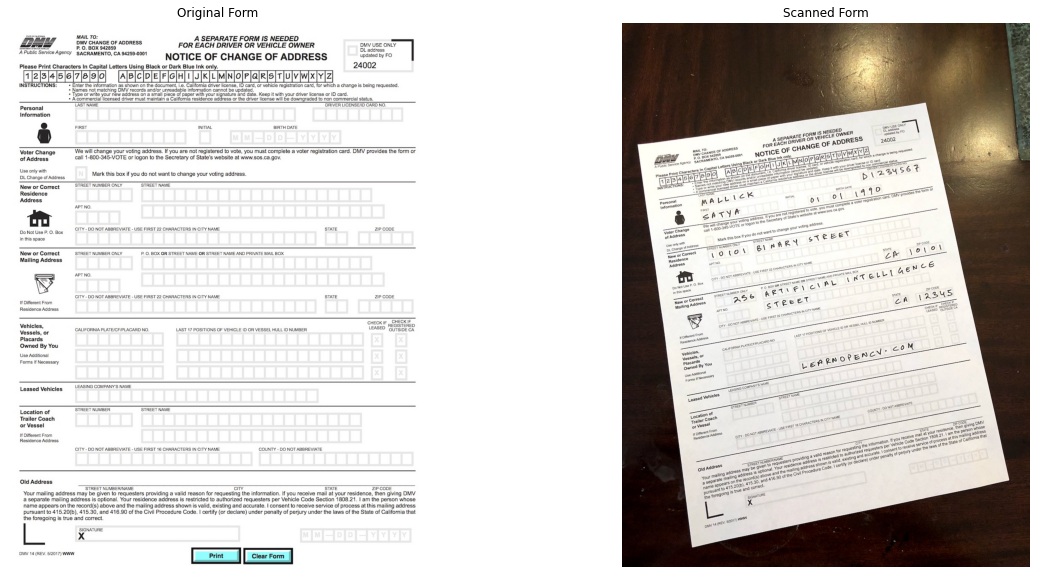

In [11]:
# Display Images

plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")

## Step 2: Find keypoints in both Images

We use ORB (Oriented FAST and Rotated BRIEF) to extract features/keypoints and descriptors. Think of keypoints as corner points that are stable under image transformations.

For ORB, we get location, scale and orientation of corner-like features as the keypoints.

Descriptors contain info that describe the region around the keypoint and act like a sort of signature for identifying that keypoint. This is useful since they likely remain the same irrespective of orientation, exposure, lighting etc

Meaning we can check for them in multiple images to try and identify what's where.

PS: You could use any of the other feature extraction algos out there. Typically we're looking for things like edges, corners, texture etc. Stuff that's contextually relevant to the image.

**But be careful!**: Algorithms like SIFT & SURF may be better, but offically, you're supposed to pay to use them (since they're patented). ORB, on the other hand, is not, so it's free to use.



In [12]:
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  

# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Display 
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


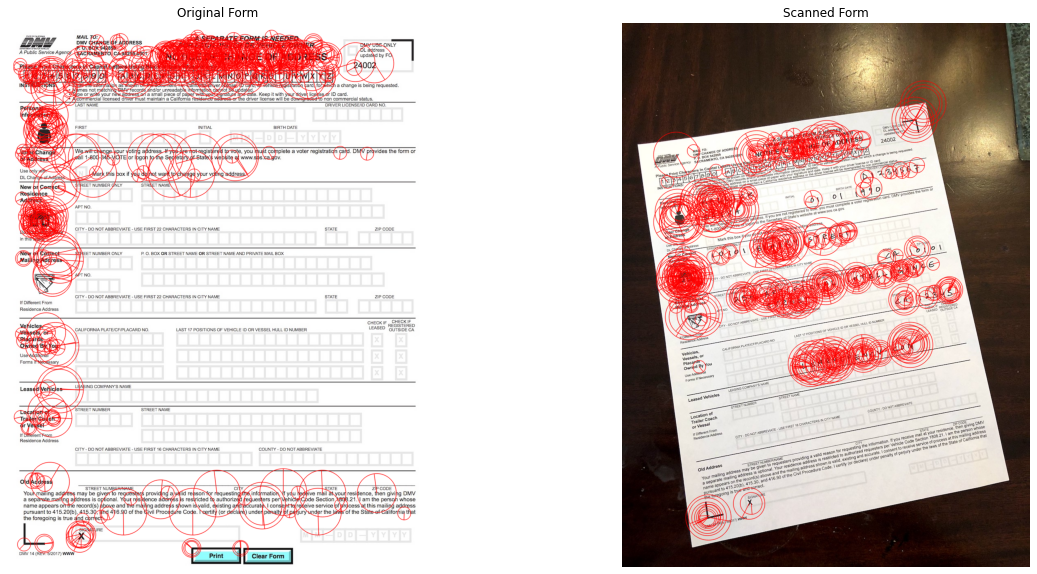

In [13]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");

## Step 3 : Match keypoints in the two image

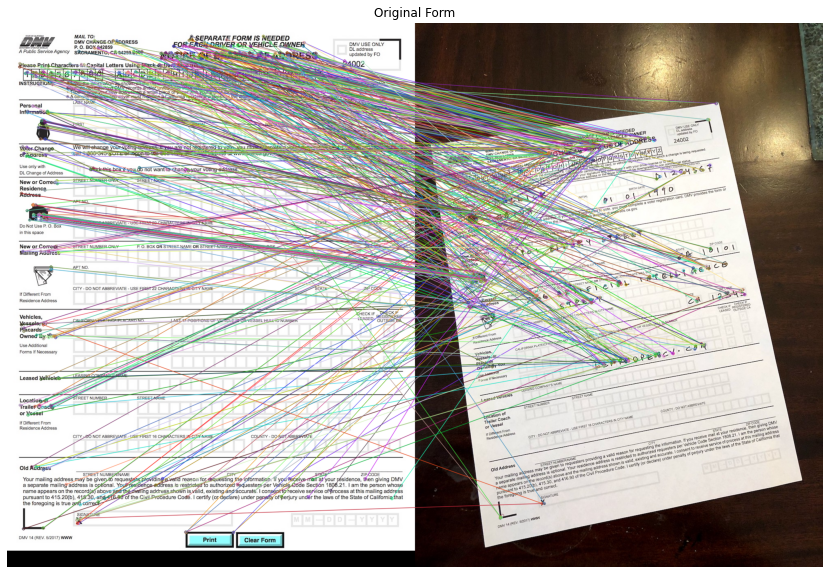

In [62]:
# Match features 
# Bruteforce algo for matching
# Hamming to compute the distance between the descriptors (since they're binary strings)
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)

# Draw matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40,10])
plt.imshow(im_matches); plt.axis('off'); plt.title("Original Form");

In [ ]:
# Sort matches by score
sorted_matches = sorted(matches, key=lambda x: x.distance, reverse=False)

# Remove not so good matches
percent_to_keep = 0.1
numGoodMatches = int(len(sorted_matches) * percent_to_keep)
matches = sorted_matches[:numGoodMatches]

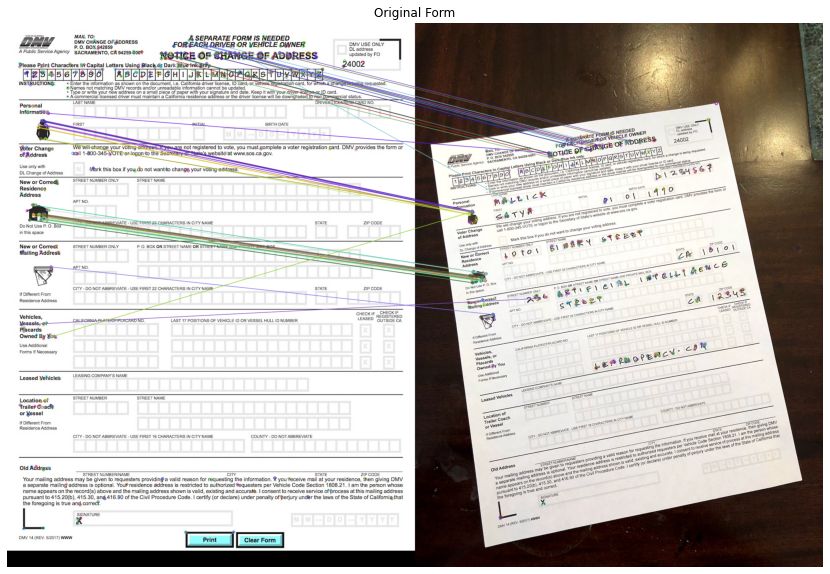

In [25]:
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40,10])
plt.imshow(im_matches); plt.axis('off'); plt.title("Original Form");


## Step 4:  Find Homography



In [26]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
  points1[i, :] = keypoints1[match.queryIdx].pt
  points2[i, :] = keypoints2[match.trainIdx].pt
  
# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

## Step 5: Warp image

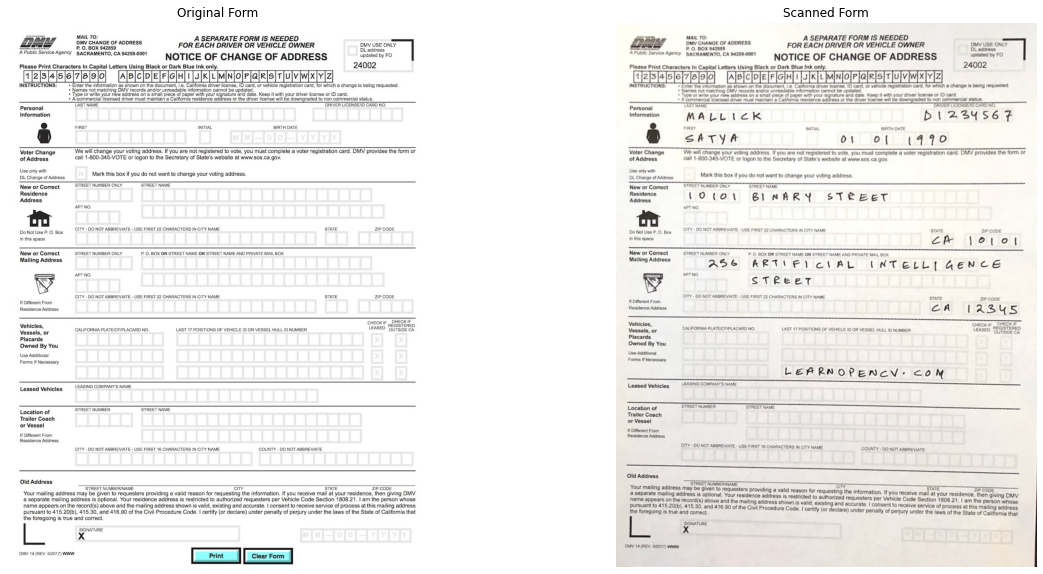

In [27]:
# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))
# Display results 
plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.imshow(im1); plt.axis('off'); plt.title("Original Form");
plt.subplot(122); plt.imshow(im2_reg); plt.axis('off'); plt.title("Scanned Form");

In [34]:
#let's save our aligned image
cv2.imwrite('aligned_image.jpg', im2_reg)

True

# OCR Using Tesseract

You'll need to [download and install](https://tesseract-ocr.github.io/tessdoc/Downloads.html) the Tesseract OCR engine.

Then you need to install pytesseract to interact with it: _pip install pytesseract_

In [36]:
import pytesseract as pt

In [37]:
#extract all the text from the form
text = pt.image_to_string(im2_reg)
print(text)

MAN TO: A SEPARATE FORM IS NEEDED
Ro ceeren ‘avonaes FOR EACH DRIVER OR VEHICLE OWNER ouy FV USE C ONLY
ADORNS GES SACRAMENTO. CAPERS NOTICE OF CHANGE OF ADDRESS wpadied by Fo
pital Letters Using Black or Dark Blue Ink on! 5 7 EGE 24002
|
PRET “btcreohl KK MMOPRRET EERE
+ Deere eg sone auras Preece ge se KO nu Sv ay
- ae

Information MALLICK b\234S6 F
@ sarye “01 of 1490

Voter Change ‘We will change your voting address. 1 you are not registered to vote, you must complete a voler registration card, OMV provides the form or
of Addross Call 1-800-345-VOTE or logon to the Secretary of State's website at www s08.ca gov.
Use onty wit
x taaes sted Mark this box if you do not want to change your voting address.
New or Correct. STREET NOMBER ORGY STReET Re
Lovee (O(O\ BINARY STREET
Address,
APT NO.

CHFY- 0 NOT ANOREVATE Ue PT 2conmACTERS WC Wl spcs mrecoe
cata a 0 ee
inti ee ch jo. oo}
New or Correct STREET NUMBER ONLY P © BOX OR STREET NAME OR STREET NAME AND PRIVATE MAR BOX
ae ASS KETIEL CI

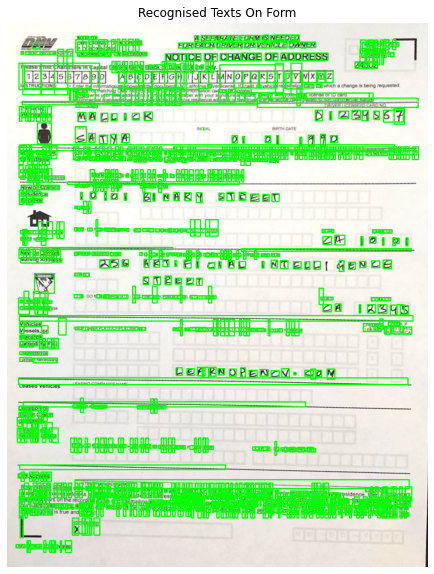

In [61]:
#let's see all the parts that were identified as characters
h, w, c = im2_reg.shape
boxes = pt.image_to_boxes(im2_reg)

img_backup = im2_reg.copy()

for b in boxes.splitlines():
    b = b.split()
    cv2.rectangle(img_backup, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0,255,0), 2)
    

plt.figure(figsize=(20, 10))  
plt.imshow(img_backup); plt.axis('off'); plt.title("Recognised Texts On Form");

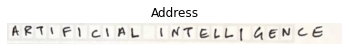

In [45]:
#but we already know what parts we need to read e.g. for P.O.Box
img_cropped = im2_reg[555:595, 315:950] #y1:y2, x1:x2
plt.imshow(img_cropped); plt.axis('off'); plt.title("Address");

In [46]:
text = pt.image_to_string(img_cropped)
print(text)

AETV EL cIAL (NTELL{ GENCE



In [48]:
im_bw = cv2.threshold(img_cropped, 127, 255, cv2.THRESH_BINARY)[1]
text = pt.image_to_string(im_bw)
print(text)

AETV EL CIAL INTELL GENCE



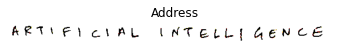

In [49]:
plt.imshow(im_bw); plt.axis('off'); plt.title("Address");

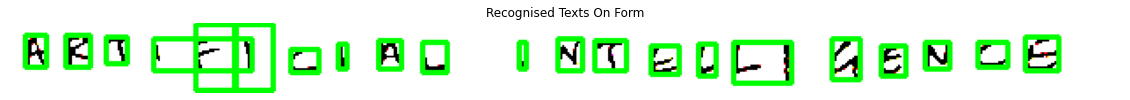

In [60]:
h, w, c = im_bw.shape
boxes = pt.image_to_boxes(im_bw)

img_backup = im_bw.copy()

for b in boxes.splitlines():
    b = b.split()
    cv2.rectangle(img_backup, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0,255,0), 2)
    

plt.figure(figsize=(20, 10))  
plt.imshow(img_backup); plt.axis('off'); plt.title("Recognised Texts On Form");

In [52]:
b

['E', '579', '13', '598', '32', '0']

In [56]:
im_bw.shape

(40, 635, 3)